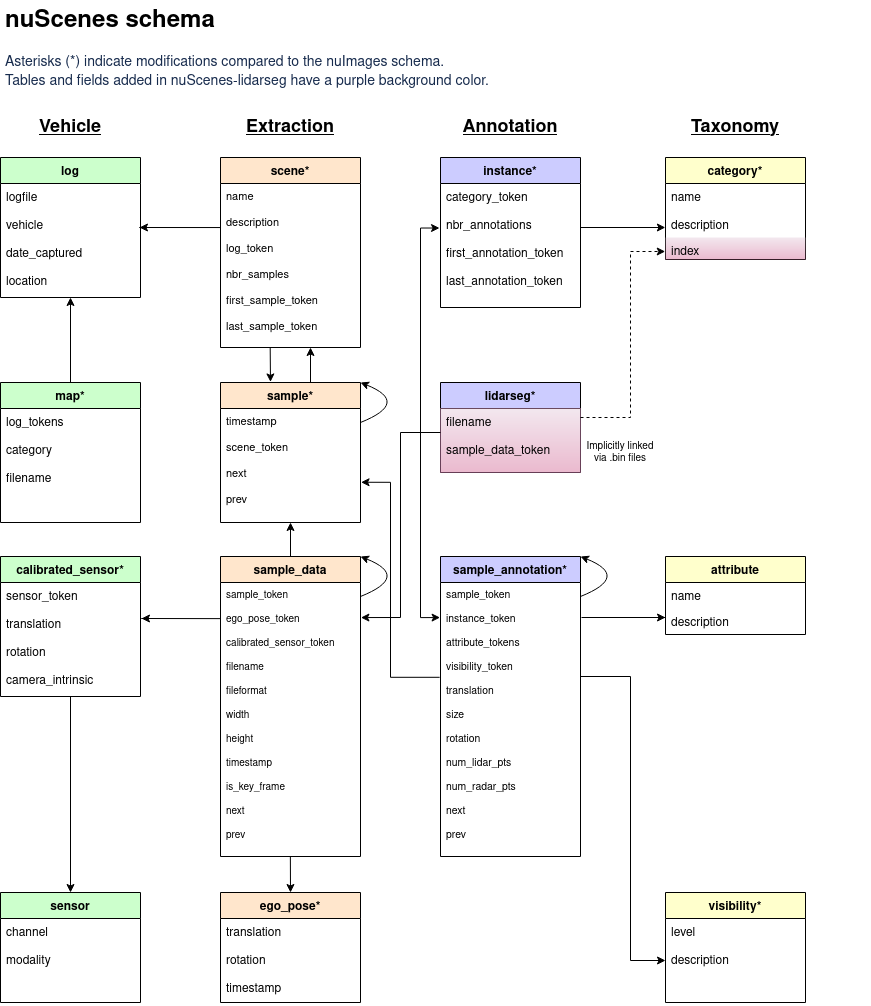

In [ ]:
# !mkdir -p data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

# !tar -xf v1.0-mini.tgz -C data/sets/nuscenes  # Uncompress the nuScenes mini split.

# !pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

# !conda install matplotlib==3.5.0

# nuScenes Map Expansion Tutorial

This is the tutorial for the nuScenes map expansion. In particular, the NuScenesMap data class.

这是 nuScenes 地图扩展的教程。特别是 NuScenesMap 数据类。

This tutorial will go through the description of each layers, how we retrieve and query a certain record within the map layers, render methods, and advanced data exploration

本教程将介绍每个图层的描述、如何在地图图层中检索和查询特定记录、渲染方法以及高级数据探索

In database terms, layers are basically tables of the map database in which we assign arbitrary parts of the maps with informative labels such as traffic_light, stop_line, walkway, etc. Refer to the discussion on layers for more details.

从数据库术语来说，图层基本上是地图数据库的表，我们在其中为地图的任意部分分配信息标签，例如交通灯、停车线、人行道等。有关图层的更多详细信息，请参阅有关图层的讨论。

# Setup

To install the map expansion, please download the files from https://www.nuscenes.org/download and copy the files into your nuScenes map folder, e.g. data/sets/nuscenes/maps.

要安装地图扩展，请从 https://www.nuscenes.org/download 下载文件并将文件复制到您的 nuScenes 地图文件夹中，例如 data/sets/nuscenes/maps。

## Initialization

We will be working with the singapore-onenorth map. The NuScenesMap can be initialized as follows:

我们将使用新加坡北一号地图。NuScenes 地图的初始化方法如下：

In [ ]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np

from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap

nusc_map = NuScenesMap(dataroot='data/sets/nuscenes', map_name='singapore-onenorth')

# Visualization

Before we go into the details, let's visualize the map.

在我们了解细节之前，让我们先将地图可视化一下。

## Rendering multiple layers

The NuScenesMap class makes it possible to render multiple map layers on a matplotlib figure.

NuScenesMap 类使得在 matplotlib 图形上渲染多个地图层成为可能。

In [ ]:
print(nusc_map.non_geometric_layers)
fig, ax = nusc_map.render_layers(nusc_map.non_geometric_layers, figsize=1)

## Rendering the lidar basemap

New: We can render the HD lidar basemap used for localization. The basemap is a bitmap image that can be underlaid for most functions (render_centerlines, render_egoposes_on_fancy_map, render_layers, render_map_patch, render_next_roads, render_record). The same BitMap class can also be used to render the semantic prior (drivable surface + sidewalk) from the original nuScenes release. Note that in this visualization we only show the lane annotations for better visibility.

新增功能：我们可以渲染用于定位的高清激光雷达底图。底图是一个位图图像，可以作为大多数函数（render_centerlines、render_egoposes_on_fancy_map、render_layers、render_map_patch、render_next_roads、render_record）的底层。相同的 BitMap 类也可用于渲染 nuScenes 原始版本中的语义先验（可行驶路面 + 人行道）。请注意，在此可视化中，我们仅显示车道注释，以提高可视性。

In [ ]:
bitmap = BitMap(nusc_map.dataroot, nusc_map.map_name, 'basemap')
fig, ax = nusc_map.render_layers(['lane'], figsize=1, bitmap=bitmap)

## Rendering a particular record of the map layer

We can render a record, which will show its global and local view

我们可以渲染一条记录，它将显示其全局和本地视图

In [ ]:
fig, ax = nusc_map.render_record('stop_line', nusc_map.stop_line[14]['token'], other_layers=[], bitmap=bitmap)

## Rendering binary map mask layers

The NuScenesMap class makes it possible to convert multiple map layers into binary mask and render on a Matplotlib figure. First let's call get_map_mask to look at the raw data of two layers:

NuScenesMap 类可以将多个地图图层转换为二进制遮罩，并在 Matplotlib 图形上渲染。首先，我们调用 get_map_mask 来查看两个图层的原始数据：

In [ ]:
patch_box = (300, 1700, 100, 100)
patch_angle = 0  # Default orientation where North is up
layer_names = ['drivable_area', 'walkway']
canvas_size = (1000, 1000)
map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layer_names, canvas_size)
map_mask[0]

Now we directly visualize the map mask retrieved above using render_map_mask:

现在我们直接使用 render_map_mask 将上面检索到的地图 mask 可视化：

In [ ]:
figsize = (12, 4)
fig, ax = nusc_map.render_map_mask(patch_box, patch_angle, layer_names, canvas_size, figsize=figsize, n_row=1)

We can also render the same map rotated by 45 degrees clockwise:

我们还可以渲染顺时针旋转 45 度的同一张地图：

In [ ]:
fig, ax = nusc_map.render_map_mask(patch_box, 45, layer_names, canvas_size, figsize=figsize, n_row=1)

## Rendering map layers on top of camera images

Let us take a nuScenes camera image and overlay the relevant map layers. Note that the projections are not perfect if the ground is uneven as the localization is 2d.

让我们拍摄一张 nuScenes 相机图像并叠加相关的地图图层。请注意，由于定位是二维的，如果地面不平整，投影效果可能不完美。

In [ ]:
# Init nuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=False)

# Pick a sample and render the front camera image.
sample_token = nusc.sample[9]['token']
layer_names = ['road_segment', 'lane', 'ped_crossing', 'walkway', 'stop_line', 'carpark_area']
camera_channel = 'CAM_FRONT'
nusc_map.render_map_in_image(nusc, sample_token, layer_names=layer_names, camera_channel=camera_channel)

## Rendering ego poses on the map

We can also plot the ego poses onto the map. This requires us to load up the NuScenes class, which can take some time.

我们还可以将自我姿态绘制到地图上。这需要加载 NuScenes 类，这可能需要一些时间。

In [ ]:
# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=False)

# Render ego poses.
nusc_map_bos = NuScenesMap(dataroot='data/sets/nuscenes', map_name='boston-seaport')
ego_poses = nusc_map_bos.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[1]['token']], verbose=False)

# Navigation

We also provide functions for navigation around the road network. For this purpose, the road layers lane, road_block and road_segment are especially useful (see definitions below). The get_next_roads(x, y) function looks at the road layer at a particular point. It then retrieves the next road object in the direction of the lane or road_block. As road_segments do not have a direction (e.g. intersections), we return all possible next roads.

我们还提供用于在道路网络中导航的函数。为此，道路图层 lane、road_block 和 road_segment 尤其有用（参见下文定义）。get_next_roads(x, y) 函数会查看特定点的道路图层。然后，它会检索该 lane 或 road_block 方向上的下一个道路对象。由于 road_segments 没有方向（例如交叉路口），因此我们返回所有可能的下一个道路。

In [ ]:
x = 873
y = 1286
print('Road objects on selected point:', nusc_map.layers_on_point(x, y), '\n')
print('Next road objects:', nusc_map.get_next_roads(x, y))

We can also visualize the next roads using the render_next_roads(x, y) function. We see that there are 3 adjacent roads to the intersection specified by (x, y).

我们还可以使用 render_next_roads(x, y) 函数可视化接下来的道路。我们看到，与 (x, y) 指定的交叉路口相邻的道路有 3 条。

In [ ]:
# 可视化当前道路
fig, ax = nusc_map.render_record('road_segment', nusc_map.layers_on_point(x, y)['road_segment'], other_layers=[], bitmap=bitmap)

# 可视化接下来的道路：
nusc_map.render_next_roads(x, y, figsize=1, bitmap=bitmap)
for token in nusc_map.get_next_roads(x, y)['road_segment']:
    fig, ax = nusc_map.render_record('road_segment', token, other_layers=[], bitmap=bitmap)

# Working with Lanes

For the prediction challenge we added connectivity information to the map expansion (v1.2) to efficiently query which lane is connected to which other lanes. Below we render the lane and lane_connector objects. The lanes and lane_connectors are defined by parametric curves. The resolution_meters parameter specifies the discretization resolution of the curve. If we set it to a high value (e.g. 100), the curves will appear as straight lines. We recommend setting this value to 1m or less.

为了应对预测挑战，我们在地图扩展 (v1.2) 中添加了连通性信息，以便高效地查询哪些车道与其他车道相连。下方我们渲染了 lane 和 lane_connector 对象。lanes 和 lane_connectors 由参数曲线定义。resolution_meters 参数指定曲线的离散化分辨率。如果我们将其设置为较高的值（例如 100），曲线将显示为直线。我们建议将此值设置为 1 米或更小。

In [ ]:
nusc_map.render_centerlines(resolution_meters=0.5, figsize=1, bitmap=bitmap)

To get the closest lane to a location, use the get_closest_lane method. To see the internal data representation of the lane, use the get_lane_record method. You can also explore the connectivity of the lanes, with the get_outgoing_lanes and get_incoming_lane methods.

要获取距离某个位置最近的车道，请使用 get_closest_lane 方法。要查看车道的内部数据表示，请使用 get_lane_record 方法。您还可以使用 get_outgoing_lanes 和 get_incoming_lane 方法探索车道的连通性。

In [ ]:
x, y, yaw = 395, 1095, 0
closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
closest_lane

In [ ]:
lane_record = nusc_map.get_arcline_path(closest_lane)
lane_record

In [ ]:
nusc_map.get_incoming_lane_ids(closest_lane)

In [ ]:
nusc_map.get_outgoing_lane_ids(closest_lane)

In [ ]:
poses = arcline_path_utils.discretize_lane(lane_record, resolution_meters=1)
poses

Given a query pose, you can also find the closest pose on a lane.

给定一个查询位姿，您还可以找到车道上最接近的位姿。

In [ ]:
closest_pose_on_lane, distance_along_lane = arcline_path_utils.project_pose_to_lane((x, y, yaw), lane_record)

In [ ]:
print(x, y, yaw)
closest_pose_on_lane

In [ ]:
# Meters
distance_along_lane

To find the entire length of the lane, you can use the length_of_lane function.

要找到车道的整个长度，可以使用 length_of_lane 函数。

In [ ]:
arcline_path_utils.length_of_lane(lane_record)

You can also compute the curvature of a lane at a given length along the lane.

您还可以计算沿车道给定长度的车道曲率。

In [ ]:
# 0 means it is a straight lane
arcline_path_utils.get_curvature_at_distance_along_lane(distance_along_lane, lane_record)

# Data Exploration

Let's render a particular patch on the map:

让我们渲染地图上的一个特定区域：

In [ ]:
my_patch = (300, 1000, 500, 1200)
fig, ax = nusc_map.render_map_patch(my_patch, nusc_map.non_geometric_layers, figsize=(10, 10), bitmap=bitmap)

A lot of layers can be seen in this patch. Lets retrieve all map records that are in this patch.

此区域中可以看到很多图层。让我们检索此区域中的所有地图记录。

*   The option within will return all non geometric records that are within the map patch
*   The option intersect will return all non geometric records that intersect the map patch

In [ ]:
records_within_patch = nusc_map.get_records_in_patch(my_patch, nusc_map.non_geometric_layers, mode='within')
records_intersect_patch = nusc_map.get_records_in_patch(my_patch, nusc_map.non_geometric_layers, mode='intersect')

Since there are a lot of records, we focus only on the layer road_segment:

由于记录很多，我们只关注 road_segment 层：

In [ ]:
layer = 'road_segment'
print('Found %d records of %s (within).' % (len(records_within_patch[layer]), layer))
print('Found %d records of %s (intersect).' % (len(records_intersect_patch[layer]), layer))

We see that using the option intersect typically returns more records than within.

我们看到，使用选项 intersect 通常比 within 返回更多的记录。

Looking at the above plot. Point (390, 1100) seems to be on a stop line. Lets verify that.

观察上面的图，点 (390, 1100) 似乎位于停止线上。我们来验证一下。

In [ ]:
my_point = (390, 1100)
layers = nusc_map.layers_on_point(my_point[0], my_point[1])
assert len(layers['stop_line']) > 0, 'Error: No stop line found!'

Indeed, we see a stop_line record.

确实，我们看到了stop_line记录。

To directly check for stop_line records, we run:

要直接检查 stop_line 记录，我们运行：

In [ ]:
nusc_map.record_on_point(my_point[0], my_point[1], 'stop_line')

Let's look at the bounds/extremities of that record

让我们看看这个记录的界限/极限

In [ ]:
nusc_map.get_bounds('stop_line', 'ac0a935f-99af-4dd4-95e3-71c92a5e58b1')

# Layers

Let us look more closely at the different map layers:

让我们更仔细地观察不同的地图层：

In [ ]:
nusc_map.layer_names

Our map database consists of multiple layers. Where each layer is made up of records. Each record will have a token identifier.

我们的地图数据库由多层构成。每层由一系列记录组成。每条记录都有一个 token 标识符。

We see how our map layers are divided into two types of layers. One set of layer belong to the geometric_layers group, another set of layers belongs to the non_geometric_layers group.

我们看到地图图层被分为两种类型。一组图层属于几何图层组，另一组图层属于非几何图层组。

1.  geometric_layers define geometric entities in the map:
    
    geographic_layers 定义地图中的几何实体：

    *   Nodes (2d points) are the basis for all geometric layers.

        节点（二维点）是所有几何层的基础。

    *   Lines consist of two or more nodes. Formally, one Line record can consist of more than one line segment.

        线由两个或多个节点组成。形式上，一个线记录可以由多个线段组成。
        
    *   Polygons consist of three or more nodes. A polygon can have holes, thus distorting its formal definition. Holes are defined as a sequence of nodes that forms the perimeter of the polygonal hole.

        多边形由三个或更多节点组成。多边形可以包含孔，因此会扭曲其正式定义。孔被定义为构成多边形孔周长的一系列节点。

2.  non_geometric_layers represent physical entities in the map. They can have more than one geometric representation (such as drivable_areas), but must be strictly of one type (e.g. road_segment, lane_divider).

    non_geometric_layers 表示地图中的物理实体。它们可以有多个几何表示（例如 drivable_areas），但必须严格属于同一类型（例如 road_segment、lane_divider）。


## 1. Geometric layers

In [ ]:
nusc_map.geometric_layers

### a. Node

The most primitive geometric record in our map database. This is the only layer that explicitly contains spatial coordinates.

我们地图数据库中最原始的几何记录。这是唯一明确包含空间坐标的图层。

In [ ]:
sample_node = nusc_map.node[0]
sample_node

### b. Line

Defines a line sequence of one or more lines and therefore consists of two or more nodes.

定义一条或多条线的线序列，因此由两个或多个节点组成。

In [ ]:
sample_line = nusc_map.line[2]
sample_line

### c. Polygon

Defines a polygon which may contain holes.

定义一个可能包含孔洞的多边形。

Every polygon record comprises of a list of exterior nodes, and zero or more list(s) of nodes that constitute (zero or more) holes.

每个多边形记录都包含一个外部节点列表，以及零个或多个构成（零个或多个）洞的节点列表。

Let's look at one polygon record:

让我们看一个多边形记录：

In [ ]:
sample_polygon = nusc_map.polygon[3]
sample_polygon.keys()

In [ ]:
sample_polygon['exterior_node_tokens'][:10]

In [ ]:
sample_holes = sample_polygon['holes'][0]
sample_holes

## 2. Non geometric layers

Every non-geometric layer is associated with at least one geometric object.

每个非几何图层都与至少一个几何对象相关联。

In [ ]:
nusc_map.non_geometric_layers

### a. Drivable Area

Drivable area is defined as the area where the car can drive, without consideration for driving directions or legal restrictions. This is the only layer in which the record can be represented by more than one geometric entity. Note: On some machines this polygon renders incorrectly as a filled black rectangle.

可行驶区域是指车辆可以行驶的区域，不受驾驶路线或法律限制的影响。这是唯一一个可以用多个几何实体表示记录的图层。注意：在某些机器上，此多边形会错误地渲染为填充黑色的矩形。

In [ ]:
sample_drivable_area = nusc_map.drivable_area[0]
sample_drivable_area

In [ ]:
fig, ax = nusc_map.render_record('drivable_area', sample_drivable_area['token'], other_layers=[])

### b. Road Segment

A segment of road on a drivable area. It has an is_intersection flag which denotes whether a particular road segment is an intersection.

可行驶区域内的一段路。它有一个 is_intersection 标记，用于指示特定路段是否为交叉路口。

It may or may not have an association with a drivable area record from its drivable_area_token field.

它可能与其 drivable_area_token 字段中的可驾驶区域记录有关联，也可能没有关联。

In [ ]:
sample_road_segment = nusc_map.road_segment[600]
sample_road_segment

As observed, for all non geometric objects except drivable_area, we provide a shortcut to its nodes.

正如所观察到的，对于除 drivable_area 之外的所有非几何对象，我们提供了到其节点的快捷方式。

Let's take a look at a road_segment record with is_intersection == True

让我们看一下 is_intersection == True 的 road_segment 记录

In [ ]:
sample_intersection_road_segment = nusc_map.road_segment[3]
sample_intersection_road_segment

If we render this road segment we can see that it is indeed an intersection:

如果我们渲染这条路段，我们可以看到它确实是一个交叉路口：

In [ ]:
fig, ax = nusc_map.render_record('road_segment', sample_intersection_road_segment['token'], other_layers=[])

### c. Road Block

Road blocks are blocks of a road that have the same traffic direction. Multiple road blocks are grouped in a road segment.

路块是指道路上交通方向相同的区块。多个路块组成一个路段。

Within a road block, the number of lanes is consistent.

在一个路段内，车道数量是一致的。

In [ ]:
sample_road_block = nusc_map.road_block[0]
sample_road_block

Every road block has a from_edge_line_token and to_edge_line_token that denotes its traffic direction.

每个路块都有一个 from_edge_line_token 和 to_edge_line_token 来表示其交通方向。

In [ ]:
fig, ax = nusc_map.render_record('road_block', sample_road_block['token'], other_layers=[])

### d. Lanes

Lanes are parts of the road where vehicles drive in a single direction.

车道是道路的一部分，车辆在此单向行驶。

In [ ]:
sample_lane_record = nusc_map.lane[600]
sample_lane_record

Aside from the token and the geometric representation, a lane has several fields:

除了标记和几何表示之外，车道还有几个字段：

*   lane_type denotes whether cars or bikes are allowed to navigate through that lane.

    lane_type 表示汽车或自行车是否可以通过该车道。

*   from_edge_line_token and to_edge_line_token denotes their traffic direction.

    from_edge_line_token 和 to_edge_line_token 表示它们的流量方向。

*   left_lane_divider_segments and right_lane_divider_segment denotes their lane dividers.

    left_lane_divider_segments 和 right_lane_divider_segment 表示它们的车道分隔线。

*   left_lane_divider_segment_nodes and right_lane_divider_segment_nodes denotes the nodes that makes up the lane dividers.

    left_lane_divider_segment_nodes 和 right_lane_divider_segment_nodes 表示构成车道分隔带的节点。

In [ ]:
fig, ax = nusc_map.render_record('lane', sample_lane_record['token'], other_layers=[])

### e. Pedestrian Crossing

Pedestrian crossings are regions where pedestrians can legally cross the road, typically highlighted by white markings. Each pedestrian crossing record has to be on a road segment. It has the road_segment_token field which denotes the road_segment record it is associated with.

人行横道是行人可以合法过马路的区域，通常以白色标记突出显示。每条人行横道记录必须位于一个路段上。它具有 road_segment_token 字段，该字段指示与其关联的 road_segment 记录。

In [ ]:
sample_ped_crossing_record = nusc_map.ped_crossing[0]
sample_ped_crossing_record

In [ ]:
fig, ax = nusc_map.render_record('ped_crossing', sample_ped_crossing_record['token'])

### f. Walkway

A walkway or sidewalk is the typically elevated area next to a road where pedestrians are protected from vehicles on the road.

步行道或人行道通常是道路旁边抬高的区域，行人在这里可以免受道路上车辆的威胁。

In [ ]:
sample_walkway_record = nusc_map.walkway[0]
sample_walkway_record

In [ ]:
fig, ax = nusc_map.render_record('walkway', sample_walkway_record['token'])

### g. Stop Line

The physical world's stop line, even though the name implies that it should possess a line geometric representation, in reality its physical representation is an area where the ego vehicle must stop.

物理世界的停车线，虽然名字暗示它应该具有线的几何表示，但实际上它的物理表示是自我车辆必须停车的区域。

In [ ]:
sample_stop_line_record = nusc_map.stop_line[1]
sample_stop_line_record

It has several attributes:

它有几个属性：

*   stop_line_type, the type of the stop line, this represents the reasons why the ego vehicle would stop 

    stop_line_type，停车线的类型，代表车辆停车的原因

*   ped_crossing_tokens denotes the association information if the stop_line_type is PED_CROSSING.

    如果 stop_line_type 为 PED_CROSSING，则 ped_crossing_tokens 表示关联信息。

*   traffic_light_tokens denotes the association information if the stop_line_type is TRAFFIC_LIGHT.

    如果 stop_line_type 为 TRAFFIC_LIGHT，traffic_light_tokens 表示关联信息。

*   road_block_token denotes the association information to a road_block, can be empty by default. 

    road_block_token 表示与某个路块的关联信息，默认可以为空。

*   cues field contains the reason on why this this record is a stop_line. An area can be a stop line due to multiple reasons:

    cues 字段包含此记录为何成为停止线的原因。一个区域可能由于多种原因成为停止线：
    
    *   Cues for stop_line_type of "PED_CROSSING" or "TURN_STOP" are ped_crossing records.

        stop_line_type 为“PED_CROSSING”或“TURN_STOP”的提示是 ped_crossing 记录。

    *   Cues for stop_line_type of TRAFFIC_LIGHT" are traffic_light records.

        TRAFFIC_LIGHT 的 stop_line_type 提示是交通灯记录。

    *   No cues for stop_line_type of "STOP_SIGN" or "YIELD".

        没有针对“STOP_SIGN”或“YIELD”的 stop_line_type 的提示。

In [ ]:
fig, ax = nusc_map.render_record('stop_line', sample_stop_line_record['token'])

### h. Carpark Area

A car park or parking lot area.

停车场或停车场区域。

In [ ]:
sample_carpark_area_record = nusc_map.carpark_area[1]
sample_carpark_area_record

It has several attributes:

它有几个属性：

*   orientation denotes the direction of parked cars in radians.

    orientation 表示停放车辆的方向（以弧度为单位）。

*   road_block_token denotes the association information to a road_block.

    road_block_token 表示与 road_block 的关联信息。

In [ ]:
fig, ax = nusc_map.render_record('carpark_area', sample_carpark_area_record['token'])

### i. Road Divider

A divider that separates one road block from another.

将一个路块与另一个路块分开的分隔物。

In [ ]:
sample_road_divider_record = nusc_map.road_divider[0]
sample_road_divider_record

road_segment_token saves the association information to a road_segment.

road_segment_token将关联信息保存到road_segment。

In [ ]:
fig, ax = nusc_map.render_record('road_divider', sample_road_divider_record['token'])

### j. Lane Divider

A lane divider comes between lanes that point in the same traffic direction.

车道分隔线位于指向同一交通方向的车道之间。

In [ ]:
sample_lane_divider_record = nusc_map.lane_divider[0]
sample_lane_divider_record

The lane_divider_segments field consist of different nodes and their respective segment_types which denotes their physical appearance.

lane_divider_segments 字段由不同的节点及其各自的segment_types组成，segment_types表示它们的物理外观。

In [ ]:
fig, ax = nusc_map.render_record('lane_divider', sample_lane_divider_record['token'])

### k. Traffic Light

A physical world's traffic light.

物理世界的交通灯。

In [ ]:
sample_traffic_light_record = nusc_map.traffic_light[0]
sample_traffic_light_record

It has several attributes:

它有几个属性：

1.  traffic_light_type denotes whether the traffic light is oriented horizontally or vertically.

    Traffic_light_type 表示交通灯是水平方向还是垂直方向。

2.  from_road_block_tokens denotes from which road block the traffic light guides.

    from_road_block_tokens 表示交通灯所引导的路块。

3.  items are the bulbs for that traffic light.

    物品是交通灯的灯泡。

4.  pose denotes the pose of the traffic light.

    pose 表示交通灯的位姿。

让我们检查一下 items 字段

In [ ]:
sample_traffic_light_record['items']

As mentioned, every entry in the items field is a traffic light bulb. It has the color information, the shape information, rel_pos which is the relative position, and the to_road_block_tokens that denotes to which road blocks the traffic light bulb is guiding.

如上所述，items 字段中的每个条目都是一个交通信号灯。它包含颜色信息、形状信息、rel_pos（相对位置）以及 to_road_block_tokens（指示交通信号灯引导前往哪个路块）。

In [ ]:
fig, ax = nusc_map.render_record('traffic_light', sample_traffic_light_record['token'])